<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/da_sfew_expw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dataset SFEW : Source (Biased)
- Datest EXPW : Target
- Model
  - CNN with Classifier
  - CNN with Classifier and Domain Classifier
- Train
  - Standard Train - Source : SFEW
  - DANN - Source - SFEW, Target - EXPW
- Test
  - Standard - SFEW, EXPW
  - DANN - SFEW, EXPW

In [ ]:
!pip install torchinfo --quiet
!pip install torch-summary --quiet

In [ ]:
#@title Import libraries
import numpy as np
import torch # for pytorch functions
import torchvision.transforms as transforms # transformation with respect to mean, std, 3 channel
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images

import random # for random image index
import torch.nn as nn # for network

from tqdm import tqdm # for beautiful model training updates
import torch.optim as optim # for optimizer
import torch.nn.functional as F # functional

import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
from torch.utils.data import DataLoader, Dataset
import os
import zipfile


import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title Cuda, Seed etc.
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (f' Device : {device}')
# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : False
 Device : cpu


## SFEW dataset related
We are using SFEW dataset, which contains ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] classes

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_PATH = '/content/drive/MyDrive/sfew'
EXTRACT_BASE_PATH = '/content/sample_data'
EXTRACT_DIR = os.path.join(EXTRACT_BASE_PATH,'sfew')
if not os.path.exists(EXTRACT_DIR):
  # create directory
  os.makedirs(EXTRACT_DIR)
  print(f'Directory {EXTRACT_DIR} created successfully.')
else:
    print(f'Directory {EXTRACT_DIR} already exists.')

Directory /content/sample_data/sfew already exists.


In [ ]:
# extracting data into EXTRACT_DIR
# Open the zip file
ZIP_FILE_PATH = os.path.join(BASE_PATH,'SFEW_2.zip')
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # printing all the contents of the zip file
    zip_ref.printdir()
    # Extract all files to the specified directory
    zip_ref.extractall(EXTRACT_DIR)
print("File extraction complete.")

File Name                                             Modified             Size
Test/SFEW_2_Test.zip                           2015-07-08 14:11:20    199060703
Test/Test_Aligned_Faces.zip                    2015-07-08 12:20:40     11029890
Test/Test_Aligned_Points.zip                   2015-07-08 12:55:12       248998
Test/Test_LPQ_Features.zip                     2015-07-08 12:22:44       467744
Test/Test_PHOG_Features.zip                    2015-07-08 12:19:32      7259705
Train/Angry.zip                                2015-05-17 00:14:22     96754962
Train/Disgust.zip                              2015-05-17 12:41:38     32233965
Train/Fear.zip                                 2015-05-17 13:06:54     41873696
Train/Happy.zip                                2016-10-12 17:15:44    119766884
Train/Neutral.zip                              2015-05-17 02:07:38     82149409
Train/Sad.zip                                  2015-05-17 12:25:48    101196826
Train/Surprise.zip                      

In [ ]:
labels=['angry','disgust','fear','happy','neutral','sad','surprise']

In [ ]:
# finding directories after unzip in EXTRACT_DIR
print(os.listdir(EXTRACT_DIR))
dict_dataset = {'TRAIN_DIR' : os.path.join(EXTRACT_DIR,'Train'),
                'TEST_DIR' : os.path.join(EXTRACT_DIR,'Test'),
                'VAL_DIR' : os.path.join(EXTRACT_DIR,'Val')}

for dir_name, dir in dict_dataset.items():
  for zips in os.listdir(dir):
    temp_file_name = (zips).split(".")[0]
    if temp_file_name in labels:
      print (dir, zips, temp_file_name)
      with zipfile.ZipFile(os.path.join(dir,zips), 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'...completed for {dir}/{zip}')


['Val', 'Test', 'Train']


In [ ]:
# Train Phase transformations
#TODO: Use albumentations in later versions, first iteration does not include any transformations
mean_ds = [0.2197, 0.1858, 0.1569]
std_dev_ds =[0.1810, 0.1635, 0.1511]

sfew_train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_ds, std_dev_ds)
                                       ])

# Val Phase transformations
sfew_val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_ds, std_dev_ds)
                                     ])

In [ ]:
# dataset
sfew_train_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=sfew_train_transforms)
sfew_val_ds = ImageFolder(root=dict_dataset['VAL_DIR'],
                       transform=sfew_val_transforms)

In [ ]:
# for sample in train_pre_norm_ds:
#   print(sample[0])
#   break

for sample in sfew_train_ds:
  print(sample[0].shape, "\n",sample[0],"\n", sample[1])
  break

torch.Size([3, 224, 224]) 
 tensor([[[-1.1921, -1.1921, -1.1705,  ..., -1.1921, -1.2138, -1.1921],
         [-1.2138, -1.2138, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.2138],
         ...,
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921],
         [-1.1921, -1.1921, -1.1921,  ..., -1.1921, -1.1921, -1.1921]],

        [[-1.1124, -1.1124, -1.1364,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1364, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1364],
         ...,
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1124],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1124, -1.1364],
         [-1.1124, -1.1124, -1.1124,  ..., -1.1124, -1.1364, -1.1124]],

        [[-1.0124, -1.0124, -1.0124,  ..., -1.0124, -1.0124, -1.0124],
         [-0.9865

In [ ]:
# dataloader arguments
BATCH_SIZE = 16
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
sfew_train_loader = DataLoader(sfew_train_ds, **dataloader_args)

# val dataloader
sfew_val_loader = DataLoader(sfew_val_ds, **dataloader_args)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset_loader,label_names,num_images=5):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    images[i] = images[i] / 2 + 0.5 # unnormalize, though not the best way
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")

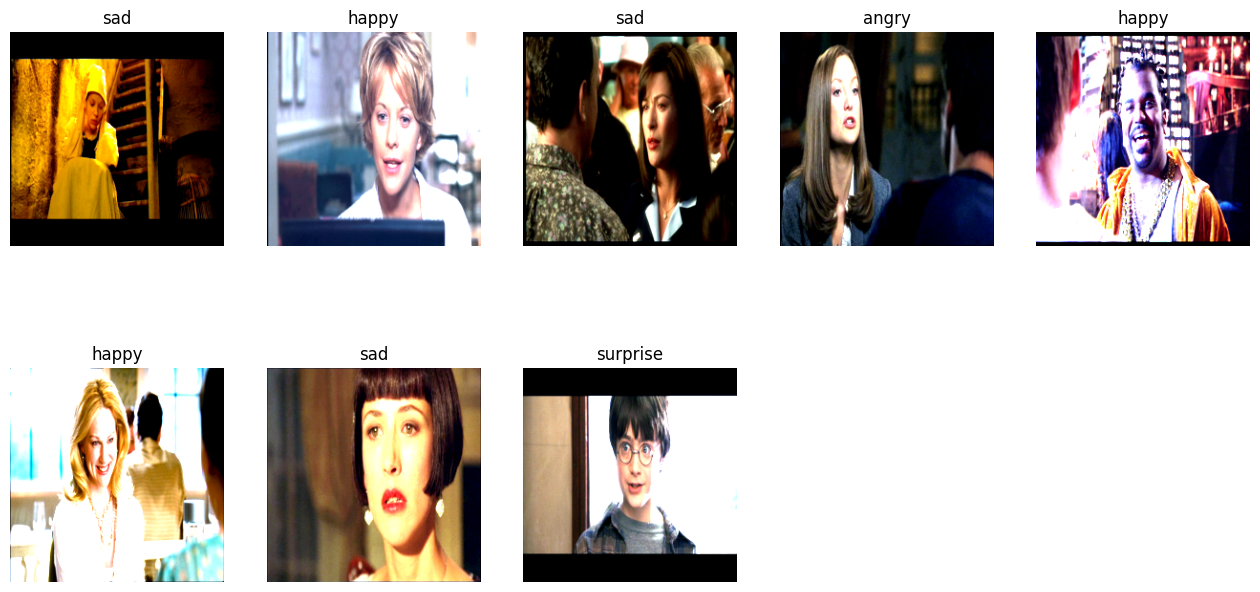

In [ ]:
show_batch(sfew_train_loader,labels,8)

## EXPW Dataset Related
We are using EXPW dataset, which contains `['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']` classes


In [ ]:
#using opendatasets to install dataset from kaggle
!pip install opendatasets --upgrade --quiet
import opendatasets as od

import os
link2="https://www.kaggle.com/datasets/mohammedaaltaha/expwds"
#011960f626b19ef4ab6e3f9ffe8ba027
od.download(link2, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saigokhale
Your Kaggle Key: ··········


100%|██████████| 7.68G/7.68G [01:09<00:00, 118MB/s]


In [ ]:
DATA_DIR ='/content/expwds/origin'

In [ ]:
os.listdir(DATA_DIR)[:20]

['annoyed_African_4.jpg',
 'anxious_european_651.jpg',
 'awe_family_482.jpg',
 'astound_girl_370.jpg',
 'awe_yang_103.jpg',
 'distaste_bos_878.jpg',
 'anxious_black_348.jpg',
 'crying_expression_675.jpg',
 'hostile_boy_546.jpg',
 'awe_yang_690.jpg',
 'annoyed_black_721.jpg',
 'amazed_actor_414.jpg',
 'angry_black_46.jpg',
 'frightened_man_144.jpg',
 'annoyed_european_234.jpg',
 'awe_soldier_910.jpg',
 'awe_old_405.jpg',
 'astound_european_501.jpg',
 'awe_girl_246.jpg',
 'astound_soldier_422.jpg']

In [ ]:
from numpy import loadtxt
file = open("/content/expwds/label/label.lst","r")
data = file.readlines() #(file,delimiter="\n")

print(type(data))
print(data[:5])

<class 'list'>
['angry_actor_104.jpg 0 28 113 226 141 22.9362 0\n', 'angry_actor_109.jpg 0 31 157 345 219 50.3056 0\n', 'angry_actor_120.jpg 1 53 53 372 372 13.9434 2\n', 'angry_actor_13.jpg 0 77 51 362 388 85.8104 3\n', 'angry_actor_132.jpg 0 95 31 412 476 82.3948 0\n']


In [ ]:

image_dict={}
for item in data:
  values=item.split(" ")
  image=values[0]
  label=values[-1].replace("\n", "")
  image_dict[image]=int(label)
  #image_dict[image]=label
# print(image_dict)

In [ ]:

labels_map={"0":"angry",
"1":"disgust",
"2":"fear",
"3":"happy",
"4":"sad",
"5":"surprise",
"6":"neutral"}

labels=list(labels_map.values())

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, im_path, data_dict, transform=None):
        self.data = data_dict
        self.transform = transform
        self.im_path= im_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = list(self.data.keys())[idx]
        label = self.data[img_name]
        img = Image.open(self.im_path+"/"+img_name)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
im_path="/content/expwds/origin"

#Train Validation Split in 80-20 ratio
total_im=len(image_dict)
num_train=int(len(image_dict)*0.8)
print(num_train)
num_val=total_im-num_train
print(num_val)
print(num_train+num_val)

full_list_dict=list(image_dict.items())
random.shuffle(full_list_dict)

train_list_dict=full_list_dict[:num_train]
val_list_dict=full_list_dict[num_train:num_train+num_val]
random.shuffle(train_list_dict)
random.shuffle(val_list_dict)

54476
13620
68096


In [ ]:

train_pre_norm_ds = CustomDataset(im_path, dict(train_list_dict), transform=torchvision.transforms.ToTensor())
print(f'Number of images in train_ds: {len(train_pre_norm_ds)}')

Number of images in train_ds: 54476


In [ ]:
expw_mean_ds = [0.3917, 0.3120, 0.2759]
expw_std_dev_ds =[0.2205, 0.2134, 0.2277]

# Train Phase transformations
#TODO: Use albumentations in later versions, first iteration does not include any transformations
expw_train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(expw_mean_ds, expw_std_dev_ds)
                                       ])

# Val Phase transformations
expw_val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(expw_mean_ds, expw_std_dev_ds)
                                     ])

In [ ]:
expw_train_ds = CustomDataset(im_path, dict(train_list_dict), transform=expw_train_transforms)
expw_valid_ds = CustomDataset(im_path, dict(val_list_dict), transform=expw_val_transforms)

In [ ]:
# dataloader arguments
BATCH_SIZE = 16
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
expw_train_loader = DataLoader(expw_train_ds, **dataloader_args)

# test dataloader
expw_val_loader = DataLoader(expw_valid_ds, **dataloader_args)

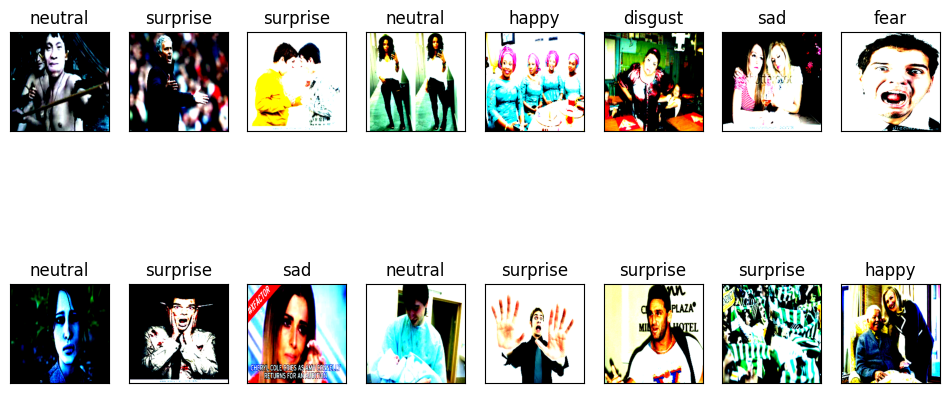

In [ ]:
from PIL import Image

def show_batch(dl, class_labels):
  for images, label in dl:
    try:
    # for images, label in dl:
        fig = plt.figure(figsize=(12, 6))
        for i in range(images.shape[0]):
          ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
          ax.imshow(images[i].permute(1,2,0))
          ax.set_title(class_labels[label[i]])
        break
    except:
      print(label[i])

show_batch(expw_train_loader, labels)

## Model Related

In [ ]:
from torch.autograd import Function

#@title Gradient Reversal Layer
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.alpha
        return grad_input, None

In [ ]:
#@title Model Definition
import torchvision.models as models

class DANN(nn.Module):
    def __init__(self, num_classes):
        super(DANN, self).__init__()

        self.feature_extractor = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])


        self.class_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256,2)
        )

    def forward(self, x, grl_lambda=1.0):
        features = self.feature_extractor(x)

        if grl_lambda is not None:
            reverse_features = GradientReversalLayer.apply(features, grl_lambda)
            domain_output = self.domain_classifier(reverse_features)
            return features, self.class_classifier(features), domain_output
        else:
            return features, self.class_classifier(features)

NameError: ignored

In [ ]:
# Hyperparameters
num_classes = 7
lr = 0.01
grl_lambda = 0.3
num_epochs = 2

In [ ]:
# Initialize the DANN model

dann_model = DANN(num_classes)
optimizer = optim.Adam(dann_model.parameters(), lr=lr)

In [ ]:
dann_model

let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradulaly changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [ ]:
#@title Source Target selection
source = 'sfew'
target = 'expw'

if source == 'sfew' and target == 'expw': # SOURCE : sfew, TARGET: expw
  dl_source_train = sfew_train_loader
  dl_source_val = sfew_val_loader
  dl_target_train = expw_train_loader
  dl_target_val = expw_val_loader
else: # SOURCE : expw, TARGET: sfew
  dl_source_train = expw_train_loader
  dl_source_val = expw_val_loader
  dl_target_train = sfew_train_loader
  dl_target_val = sfew_val_loader

In [ ]:
#@title Checking if the model, dataloader etc. are working by sending data to untrained model
x0_s, y0_s = next(iter(dl_source_train))
x0_t, y0_t = next(iter(dl_target_train))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

dann_model(x0_s.to(device))[1], dann_model(x0_t.to(device))[1]

In [ ]:
#@title Typical training function

def train(model, device, train_loader, criterion, scheduler, optimizer):
    """Function to train the model
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_loader (instance): Torch Dataloader instance for trainingset
        criterion (instance): criterion to used for calculating the loss
        scheduler (function): scheduler to be used
        optimizer (function): optimizer to be used
    Returns:
        float: accuracy and loss values
    """
    model.train()
    pbar = tqdm(train_loader)
    lr_trend = []
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)


        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch
        # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop,
        # ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred,_ = model(data) # we are interested in only class prediction
        # Calculate loss
        loss = criterion(y_pred, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # updating LR
        if scheduler:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
                lr_trend.append(scheduler.get_last_lr()[0])

        train_loss += loss.item()


        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # Update pbar-tqdm
        pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/(batch_idx + 1):.5f} Accuracy={100*correct/processed:0.2f}%')

    return 100*correct/processed, train_loss/(batch_idx + 1), lr_trend

In [ ]:
#@title Typical test function
def test(model, device, test_loader, criterion):
    """put model in eval mode and test it
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        test_loader (instance): Torch Dataloader instance for testset
        criterion (instance): criterion to used for calculating the loss
    Returns:
        float: accuracy and loss values
    """
    model.eval()
    test_loss = 0
    correct = 0
    #iteration = len(test_loader.dataset)// test_loader.batch_size
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data) # we are interested in only class prediction
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss

In [ ]:
def save_model(model, epoch, optimizer, path):
    """Save torch model in .pt format
    Args:
        model (instace): torch instance of model to be saved
        epoch (int): epoch num
        optimizer (instance): torch optimizer
        path (str): model saving path
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, path)

In [ ]:
def fit_model(net, optimizer, criterion, device, NUM_EPOCHS,train_loader, test_loader, scheduler=None, save_best=False):
    """Fit the model
    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        criterion (instance): criterion to used for calculating the loss
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        test_loader (instance): Torch Dataloader instance for testset
        scheduler (function, optional): scheduler to be used. Defaults to None.
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered
    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    lr_trend = []
    if save_best:
        min_val_loss = np.inf
        save_path = 'model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))

        train_acc, train_loss, lr_hist = train(
            model=net,
            device=device,
            train_loader=train_loader,
            criterion=criterion ,
            optimizer=optimizer,
            scheduler=scheduler
        )
        test_acc, test_loss = test(net, device, test_loader, criterion)
        # update LR
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)

        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not improve from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        lr_trend.extend(lr_hist)

    if scheduler:
        return net, (training_acc, training_loss, testing_acc, testing_loss, lr_trend)
    else:
        return net, (training_acc, training_loss, testing_acc, testing_loss)

In [ ]:
# #@title Model fit for Typical Model (Non-DANN)

# lr = 1e-3
# n_epochs = 5

# # Setup optimizer as usual
# typical_model = DANN(num_classes)

# optimizer = optim.Adam(typical_model.parameters(), lr)

# # Two losses functions this time
# loss_fn_class = torch.nn.CrossEntropyLoss()
# loss_fn_domain = torch.nn.BCELoss()

# # # We'll train the same number of batches from both datasets
# # max_batches = min(len(dl_source_train), len(dl_target_train))
# # print(len(dl_source_train), len(dl_target_train), max_batches)

# typical_model, tuple_acc_loss = fit_model(net = typical_model.to(device),
#                                           optimizer = optimizer,
#                                           criterion = loss_fn_class,
#                                           device = device,
#                                           NUM_EPOCHS = n_epochs,
#                                           train_loader = dl_source_train,
#                                           test_loader=dl_source_val,
#                                           scheduler=None,
#                                           save_best=True)

In [ ]:
# # Training loop
# for epoch in range(num_epochs):
#     for source_data, target_data in zip(sfew_train_loader, expw_train_loader):
#         source_inputs, source_labels = source_data
#         target_inputs, _ = target_data

#         # Prepare domain labels (source=0, target=1)
#         source_domain_labels = torch.zeros(source_inputs.size(0), 1)
#         target_domain_labels = torch.ones(target_inputs.size(0), 1)

#         # Forward pass for source data
#         optimizer.zero_grad()
#         source_features, source_class_output, _ = dann_model(source_inputs,alpha = 0.3)
#         source_class_loss = nn.CrossEntropyLoss()(source_class_output, source_labels)

#         # Forward pass for target data with domain adaptation
#         _, target_class_output, target_domain_output = dann_model(target_inputs, alpha)
#         target_domain_loss = nn.BCEWithLogitsLoss()(target_domain_output, target_domain_labels)

#         total_loss = source_class_loss + target_domain_loss
#         total_loss.backward()
#         optimizer.step()